# Convolutionnal neural network - Exercise
## Using a CNN to learn and classify handwritten digits, using the MNIST database.

## Overview  
In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.

A convolutional neural network consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product. The activation function is commonly a ReLU layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution.

The PyTorch machine learning library will be used in this exercise.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [8]:
transform = transforms.ToTensor()
train_set = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=1000, num_workers=2)

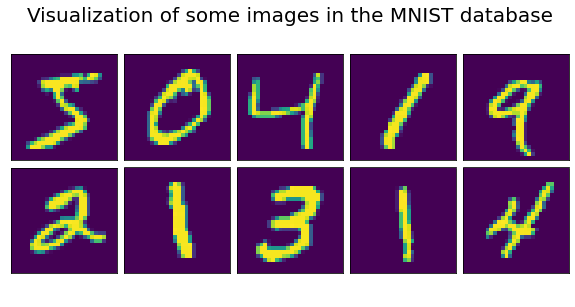

In [17]:
images = []
for i in range(10):
    images.append(train_set[i][0].permute(1,2,0))

fig = plt.figure(figsize=(10., 5.))
plt.title("Visualization of some images in the MNIST database",fontsize=20)
plt.xticks(())
plt.yticks(())
plt.box(False)
grid = ImageGrid(fig, 111,nrows_ncols=(2, 5),axes_pad=0.1, )
for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self, n_in, n_out):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_in, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout(p=0.5)
        self.maxpool2d = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_out)

    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool2d(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.maxpool2d(out)
        out = torch.relu(out)  
        out = out.flatten(1)  
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out 

In [11]:
#start_time = time.time()

device = torch.device('cuda')
total_epochs=3
learning_rate=0.01

model = CNN(n_in=1, n_out=10) 
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

def do_epoch(model, device, train_loader, optimizer, loss_fn):
    model.train() 
    losses = []
    
    for batch_idx, (x, y) in enumerate(train_loader):
        
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

        losses.append(loss.item())
    return np.mean(losses)

def test_model(model, device, test_loader):
    model.eval() 
    correct = 0
    for _, (x, y) in enumerate(test_loader):

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        probas = torch.softmax(logits,1)
        
        predictions = probas.argmax(dim=1, keepdim=True)
        correct += predictions.eq(y.view_as(predictions)).sum().item()
    acc = correct / len(test_loader.dataset)
    print('Test Epoch {} :\t Accuracy: {:.3f}'.format(epoch, acc))
    return acc


train_losses = []   
test_accuracies = []   

for epoch in range(total_epochs):
    mean_train_loss = do_epoch(model, device, train_loader, optimizer, loss_fn) 
    mean_test_acc = test_model(model, device, test_loader)  
    train_losses.append(mean_train_loss)
    test_accuracies.append(mean_test_acc)

#print("--- %s seconds ---" % (time.time() - start_time))

Test Epoch 0 :	 Accuracy: 0.971
Test Epoch 1 :	 Accuracy: 0.980
Test Epoch 2 :	 Accuracy: 0.986


# Results

## Plotting the accuracy and train loss over time.

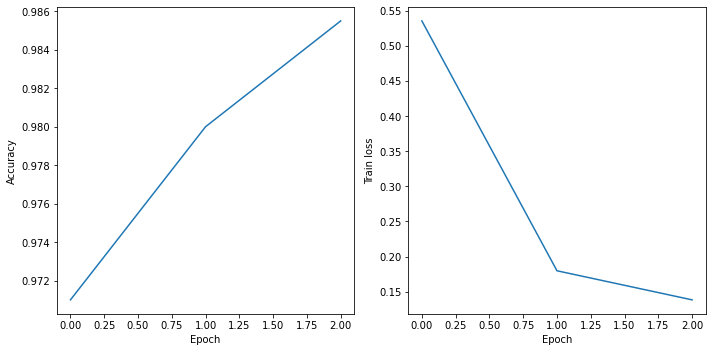

In [12]:
fig = plt.figure(figsize=(10., 5.))
ax1 = plt.subplot(121)
ax1.plot(test_accuracies)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

ax2 = plt.subplot(122)
ax2.plot(train_losses)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Train loss")

plt.tight_layout()
plt.show()